In [37]:
import numpy as np
import bz2
from collections import Counter
import re
import nltk
import torch
import math
import random
import keras
from torch import nn
from torch import optim
from torch import Tensor
from torch import LongTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import seaborn as sns
import itertools

In [38]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)
nn_Softargmax = nn.Softmax  # fix wrong name

In [39]:
train_dir = '/media/data/artifacts/2016/train/'
test_dir = '/media/data/artifacts/2016/test/'
train_labels_dir = '/media/data/artifacts/2016/train_labels.txt'
test_labels_dir = '/media/data/artifacts/2016/test_labels.txt'
word2vec_model_dir = '/media/data/artifacts/2016/final256.model'
model_dir = '/media/data/artifacts/2016/models/'

In [40]:
!wc -l /media/data/artifacts/2016/train_labels.txt

154800 /media/data/artifacts/2016/train_labels.txt


In [41]:
!wc -l /media/data/artifacts/2016/test_labels.txt

17200 /media/data/artifacts/2016/test_labels.txt


In [42]:
x = !ls -l /media/data/artifacts/2016/train | wc -l
len_train = int(x[0]) - 1
y = !ls -l /media/data/artifacts/2016/test | wc -l
len_test = int(y[0]) - 1

In [43]:
print(len_train)
print(len_test)

154800
17200


### Load word2 vec model

In [44]:
word2vec_model = KeyedVectors.load(word2vec_model_dir, mmap='r')

20-Mar-21 21:48:02 - loading Word2VecKeyedVectors object from /media/data/artifacts/2016/final256.model
20-Mar-21 21:48:05 - loading vectors from /media/data/artifacts/2016/final256.model.vectors.npy with mmap=r
20-Mar-21 21:48:05 - setting ignored attribute vectors_norm to None
20-Mar-21 21:48:05 - loaded /media/data/artifacts/2016/final256.model


In [45]:
len(word2vec_model.wv.vocab)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


850193

### Create train and test labels

In [46]:
train_label_dict={}
count = 0
with open(train_labels_dir) as file:
    for _ in range(len_train):
        line  = file.readline().strip().split(",")
#         if line[0] in train_label_dict and line[1] == '0':
#             count+=1
#             print(line[0],line[1])
        train_label_dict[line[0]] = int(line[1])

In [47]:
test_label_dict={}
with open(test_labels_dir) as file:
    for _ in range(len_test):
        line  = file.readline().strip().split(",")
        test_label_dict[line[0]] = int(line[1])

### Create word2index and index2word dict

In [48]:
len(train_label_dict)

154800

In [49]:
len(test_label_dict)

17200

In [50]:
tokenizer = Tokenizer(filters='#\n')
tokenizer.fit_on_texts(word2vec_model.wv.vocab.keys())
word_index = tokenizer.word_index

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [51]:
idx2word = {v: k for k, v in word_index.items()}

In [52]:
len(word_index)

850192

### Create Train and Test Generators

In [53]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, files_list, labels):
        'Initialization'
        self.labels = labels
        self.files_list = files_list

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.files_list)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.files_list[index]

        train_dir = '/media/data/artifacts/2016/train/'
        # Load data and get label
        #one_file = torch.load(train_dir + ID)
        one_file = open(train_dir + ID,'r').read().strip() 
        # one_file = torch.load(train_dir + ID + '.txt')

        X =  sequence.pad_sequences(tokenizer.texts_to_sequences([one_file]),maxlen=4000, padding='post',truncating='post')
    
        

        if self.labels[ID] == 1:
            y = [0,1]
        else:
            y = [1,0]

        #y = self.labels[ID]
        #y = torch.from_numpy(y)
        y = torch.FloatTensor(y)

        return X.squeeze(), y


In [54]:
class TestDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, files_list, labels):
        'Initialization'
        self.labels = labels
        self.files_list = files_list

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.files_list)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.files_list[index]

        test_dir = '/media/data/artifacts/2016/test/'
        # Load data and get label

        one_file = open(test_dir + ID,'r').read().strip() 

        X =  sequence.pad_sequences(tokenizer.texts_to_sequences([one_file]),maxlen=4000, padding='post',truncating='post')
    
        

        if self.labels[ID] == 1:
            y = [0,1]           #malicious
        else:
            y = [1,0]           #benign

        #y = self.labels[ID]
        #y = torch.from_numpy(y)
        y = torch.FloatTensor(y)

        return X.squeeze(), y

In [55]:
train = list(train_label_dict.keys())
test = list(test_label_dict.keys())
partition = {}
partition['train'] = train
partition['test'] = test
train_labels= train_label_dict
test_labels= test_label_dict

In [56]:
# import itertools
# t=dict(itertools.islice(test_labels.items(),8000))
# partition['test'] = t
# len(t)

In [57]:
params1 = {'batch_size': 4,
          'shuffle': True,
          'drop_last': True,
          'num_workers': 5}

params2 = {'batch_size': 4,
          'shuffle': False,
          'drop_last': True,
          'num_workers': 5}
max_epochs = 1

# Train Generators
train_set = TrainDataset(partition['train'], train_labels)
#training_generator = torch.utils.data.DataLoader(train_set, **params1)
training_set, val_set = torch.utils.data.random_split(train_set, [140800, 14000])
training_generator = torch.utils.data.DataLoader(training_set, **params1)
validation_generator = torch.utils.data.DataLoader(val_set, **params1)

# Test Generators
test_set = TestDataset(partition['test'], test_labels)
test_generator = torch.utils.data.DataLoader(test_set, **params2)



In [58]:
print(len(training_set))
print(len(val_set))
print(len(test_set))

140800
14000
17200


In [59]:
print(len(training_generator))
print(len(validation_generator))
print(len(test_generator))

35200
3500
4300


### Check GPU

In [60]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

### Training

In [61]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, p, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = nn_Softargmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        # print('MHA attn weight shape:', A.shape)
        # print('MHA output shape:', H.shape)
        
        return H, A

In [62]:
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()
        
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

In [63]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, p=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads, p)
        self.cnn = CNN(d_model, conv_hidden_dim, p)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, attn_weights = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weights

In [64]:
def create_sinusoidal_embeddings(nb_p, dim, E):
    theta = np.array([
        [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_p)
    ])
    E[:, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    E[:, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    E.detach_()
    E.requires_grad = False
    E = E.to(device)

class Embeddings(nn.Module):
    def __init__(self, embedding_matrix, d_model, vocab_size, max_position_embeddings, p):
        super().__init__()
#         self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # self.word_embeddings = nn.Embedding(vocab_size, d_model)
        # # pretrained_weight is a numpy matrix of shape (num_embeddings, d_model)
        # self.word_embeddings.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # self.word_embeddings.weight.requires_grad=False

        self.word_embeddings = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
        # self.word_embeddings = nn.Embedding(vocab_size, d_model)
        # self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # self.word_embeddings.weight.requires_grad=False
        
        self.position_embeddings = nn.Embedding(max_position_embeddings, d_model)
        create_sinusoidal_embeddings(
            nb_p=max_position_embeddings,
            dim=d_model,
            E=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                      # (bs, max_seq_length)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for each position id 
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)
        
        # Add them both 
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [65]:
class Encoder(nn.Module):
    def __init__(self,embedding_matrix, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embeddings(embedding_matrix, d_model, input_vocab_size,maximum_position_encoding, p)
        # self.embedding = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)


        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, p))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x, attn_weights = self.enc_layers[i](x)

        return x, attn_weights  # (batch_size, input_seq_len, d_model)

In [66]:
class TransformerClassifier(nn.Module):
    def __init__(self,embedding_matrix, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        # self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
        #                  maximum_position_encoding=10000)
        self.encoder = Encoder(embedding_matrix, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, 1)
#         self.dense11 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.tanh = nn.Tanh()
        self.softmax_fc = nn.Softmax(dim=1)
        self.dense2 = nn.Linear(4000, num_answers)

    def forward(self, x):
        x, attn_weights = self.encoder(x)
        # print('out1',x.shape)
        # [100,200,32]
        # print('attn1',attn_weights.shape)
        
        #x, _ = torch.max(x, dim=1)
        out = self.dense(x)
#         out = self.dense11(out)
        out = self.dropout(out)
        out = self.tanh(out)
        # print('out dense1',out.shape)
        # [100,200,1]
        # print('attn dense1',attn_weights.shape)
        out = out.squeeze()
        # [100,200,1]
        out = self.dense2(out)
        out = self.softmax_fc(out)
        # [100,2]
        # print('out final ',out.shape)
        # print('attn final ',attn_weights.shape)
        return out, attn_weights

In [67]:
embedding_matrix = torch.FloatTensor(word2vec_model.vectors)

In [68]:
vocab_size = len(word2vec_model.wv.vocab)+1
batch_size = 10
output_size = 2
embedding_dim = 256
#embedding_dim = 100
conv_dim = 16
n_layers = 1
drop_prob=0.3
model = TransformerClassifier(embedding_matrix, num_layers=1, d_model=embedding_dim, num_heads=2,conv_hidden_dim=conv_dim, input_vocab_size=vocab_size, num_answers=output_size)
# model= nn.DataParallel(model)
model.to(device)
model

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


TransformerClassifier(
  (encoder): Encoder(
    (embedding): Embeddings(
      (word_embeddings): Embedding(850193, 256)
      (position_embeddings): Embedding(10000, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    )
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=False)
          (W_k): Linear(in_features=256, out_features=256, bias=False)
          (W_v): Linear(in_features=256, out_features=256, bias=False)
          (W_h): Linear(in_features=256, out_features=256, bias=True)
        )
        (cnn): CNN(
          (k1convL1): Linear(in_features=256, out_features=16, bias=True)
          (k1convL2): Linear(in_features=16, out_features=256, bias=True)
          (activation): ReLU()
        )
        (layernorm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (layernorm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
    

In [69]:
columns = ['layers', 'shape', 'parameters']
df = pd.DataFrame(columns=columns)
n = []
s = []
p = []
r = []
for name, param in model.named_parameters():

    n.append(str(name))
    s.append(str(param.shape))
    p.append(str(param.numel()))
    r.append(str(param.requires_grad))


df['layers'] = n
df['shape'] = s
df['parameters'] = p
df['requires_grad'] = r
df

,layers,shape,parameters,requires_grad
0,encoder.embedding.word_embeddings.weight,"torch.Size([850193, 256])",217649408,False
1,encoder.embedding.position_embeddings.weight,"torch.Size([10000, 256])",2560000,False
2,encoder.embedding.LayerNorm.weight,torch.Size([256]),256,True
3,encoder.embedding.LayerNorm.bias,torch.Size([256]),256,True
4,encoder.enc_layers.0.mha.W_q.weight,"torch.Size([256, 256])",65536,True
5,encoder.enc_layers.0.mha.W_k.weight,"torch.Size([256, 256])",65536,True
6,encoder.enc_layers.0.mha.W_v.weight,"torch.Size([256, 256])",65536,True
7,encoder.enc_layers.0.mha.W_h.weight,"torch.Size([256, 256])",65536,True
8,encoder.enc_layers.0.mha.W_h.bias,torch.Size([256]),256,True
9,encoder.enc_layers.0.cnn.k1convL1.weight,"torch.Size([16, 256])",4096,True


In [111]:
# [ lr = 0.001,bs=200,d_model=32,conv_dim=32]
model.train()
epochs = 20
counter = 0
clip = 5
print_every = 100
valid_loss_min = np.Inf
all_weights = []
all_train_loss = []
all_val_loss = []
eps = []
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
# optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
val_loader = validation_generator
model_dir = '/media/data/artifacts/2016/models/tra/'



for epoch in range(10,epochs):
    #state_h, state_c = model.init_state(sequence_length)
    model.train()
    # h = model.init_state(batch_size)

    train_losses = []
    validation_losses = []

    for inputs, labels in training_generator:
        counter += 1
        # h = tuple([e.data for e in h])
        # h = [x.to(device) for x in h]
        inputs, labels = inputs.to(device).long(), labels.to(device)

        model.zero_grad()
        output, _ = model(inputs)
        loss = criterion(output.squeeze(), labels.float())
        # loss = f.cross_entropy(output, lables)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        
    model.eval()
    # val_h = model.init_state(batch_size)
    for inp, lab in val_loader:
        # val_h = tuple([each.data for each in val_h])
        # val_h = [x.to(device) for x in val_h]
        inp, lab = inp.to(device).long(), lab.to(device)

        out, _  = model(inp)
        val_loss = criterion(out.squeeze(), lab.float())
        #val_loss = f.cross_entropy(out, lab)
        validation_losses.append(val_loss.item())

        
    all_train_loss.append(np.mean(train_losses))
    all_val_loss.append(np.mean(validation_losses))
    eps.append(epoch+1)
    torch.save(model, model_dir + str(epoch+1) + "-tra-exp-3.pickle")
    df_loss = pd.DataFrame({'train_loss':all_train_loss})
    df_loss['validation_loss'] = all_val_loss
    df_loss['epochs'] = eps
    df_loss.to_csv(model_dir + 'tra_exp_3.csv',mode='a', sep=',')
    
    logging.info("Epoch {}: {:.6f} loss, {:.6f} val loss".format(epoch+1, np.mean(train_losses), np.mean(validation_losses)))

28-Feb-21 22:37:58 - Epoch 11: 0.218813 loss, 0.218259 val loss
28-Feb-21 23:15:59 - Epoch 12: 0.217931 loss, 0.269994 val loss
28-Feb-21 23:52:01 - Epoch 13: 0.217748 loss, 0.222012 val loss
01-Mar-21 00:27:32 - Epoch 14: 0.216860 loss, 0.210403 val loss
01-Mar-21 01:03:10 - Epoch 15: 0.216181 loss, 0.207700 val loss
01-Mar-21 01:38:26 - Epoch 16: 0.214891 loss, 0.212424 val loss
01-Mar-21 02:13:34 - Epoch 17: 0.214437 loss, 0.208430 val loss
01-Mar-21 02:48:39 - Epoch 18: 0.213096 loss, 0.207380 val loss
01-Mar-21 03:24:01 - Epoch 19: 0.212760 loss, 0.208072 val loss
01-Mar-21 03:59:19 - Epoch 20: 0.212214 loss, 0.212025 val loss


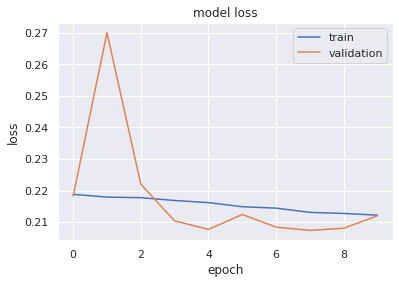

In [113]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
# fig = plt.figure(figsize=(3,6))
plt.show()
# plt.savefig(model_dir + 'loss.png', bbox_inches='tight')

In [ ]:
df_loss = pd.DataFrame({'train_loss':all_train_loss})
df_loss['validation_loss'] = all_val_loss
df_loss.to_csv(model_dir + 'tra_exp_2.csv', sep=',')

In [135]:
model_dir = '/media/data/artifacts/2016/models/tra/'
df = pd.read_csv(model_dir + 'tra_exp_2.csv')
# df.columns=['epoch', 'train_loss', 'validation_loss']
df = df[['train_loss', 'validation_loss']]

[[<matplotlib.axis.XTick at 0x7f32b83d2b90>,

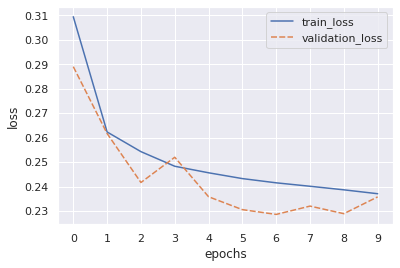

In [136]:
t = [x for x in range(0,10,1)]
sns.set(style="darkgrid")
g = sns.lineplot(data=df)
g.set(xlabel='epochs', ylabel='loss')
g.set(xticks=t)

In [139]:
torch.cuda.device_count()

1

### Save model

In [70]:
model_dir = '/media/data/artifacts/2016/models/tra/'
# torch.save(model, model_dir + "final-transfomer-4000-ep-20-5_2.pickle")
# model = torch.load(model_dir + "tra-5/" + "2-final-transfomer-4000-ep-10-5_5.pickle")
model = torch.load(model_dir + "final-tra-exp-256-1.pickle")
# model = torch.load(model_dir + 'final-transfomer.pickle', map_location=torch.device('cuda'))

### 

In [71]:
# device = torch.device("cpu")
# model= nn.DataParallel(model)
# model.to(device)

### Testing

In [75]:
def test(model, test_generator):
    test_losses = []
    num_correct = 0
    a_weights = []
    b_weights = []
    pred_label = []
    true_label = []
    prediction = []
    criterion = nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.0005)
#     model.eval()
    with torch.no_grad():
        for inputs, labels in test_generator:
            inputs, labels = inputs.to(device).long(), labels.to(device)
            output, a_out = model(inputs)

            for out in output:
    #             o = out.cpu().numpy()
                prediction.append(out.cpu().numpy())
                #o = out.round().cpu().numpy()
                # if o[0] == 0 :   #this mean _label1_ bad
                #     pred_label.append(0)
                # else:            #this mean _label2_ good
                #     pred_label.append(1)


            for label in labels:
                l = label.cpu().numpy()
                if l[0] == 0 :
                    true_label.append(1) # malicious apps
                else:
                    true_label.append(0)

            for each_a_out in a_out:
                a = each_a_out
                a = a.squeeze()
                x = a[0]
                y = a[1]
#                 a = torch.mean(a,0) #if only 1 head
                x = torch.mean(x,0)
                y = torch.mean(y,0)
                a_weights.append(x.cpu().numpy())
                b_weights.append(y.cpu().numpy())

            test_loss = criterion(output.squeeze(), labels.float())
            test_losses.append(test_loss.item())


#     print("Test loss: {:.3f}".format(np.mean(test_losses)))
#     test_acc = num_correct/len(test_generator.dataset)
    #print("Test accuracy: {:.3f}%".format(test_acc*100))
    return prediction, true_label, a_weights, b_weights, test_losses

In [76]:
prediction, true_label, a_weights,b_weights, test_losses = test(model,test_generator)
print("Test loss: {:.3f}".format(np.mean(test_losses)))

Test loss: 0.231


In [77]:
prediction1 = np.argmax(prediction, axis=1)  ## Prediction for bad reviews in terms of 0 and 1 for all test data
prediction_for_1=[] ## Prediction for bad reviews only
for each_prediction in prediction:
    prediction_for_1.append(each_prediction[1])

c = confusion_matrix(true_label,prediction1 )

In [78]:
c

array([[12366,   534],
       [  955,  3345]])

20-Mar-21 21:56:44 - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
20-Mar-21 21:56:44 - NumExpr defaulting to 8 threads.


[Text(0, 0.5, 'benign'), Text(0, 1.5, 'malicious')]

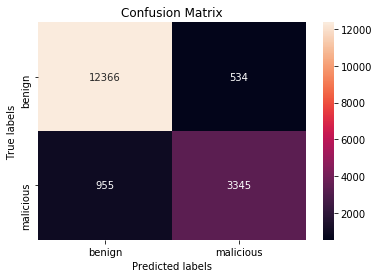

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(c, annot=True, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['benign', 'malicious']) 
ax.yaxis.set_ticklabels(['benign', 'malicious'])

#### Evaluation Metrics

In [80]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from inspect import signature

truelabel = true_label
predictedlabel = np.array(prediction1)

precision, recall, _ = precision_recall_curve(truelabel,np.array(prediction_for_1))
au = auc(recall, precision)
print("Area under graph "+str(au))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=1,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=1,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=1, average='binary')
print("Precision for Malicious apps "+str(precise_score))
print("Recall for Malicious apps "+str(rec_score))
print("F1-score for Malicious apps  " + str(f1))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=0,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=0,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=0, average='binary')
print("Precision for Benign apps "+str(precise_score))
print("Recall for Benign apps "+str(rec_score))
print("F1-score for Benign apps  " + str(f1))

Area under graph 0.9074033027880193
-------------------------------------------------
Precision for Malicious apps 0.8623356535189481
Recall for Malicious apps 0.7779069767441861
F1-score for Malicious apps  0.8179484044504217
-------------------------------------------------
Precision for Benign apps 0.928308685534119
Recall for Benign apps 0.9586046511627907
F1-score for Benign apps  0.9432134548644217


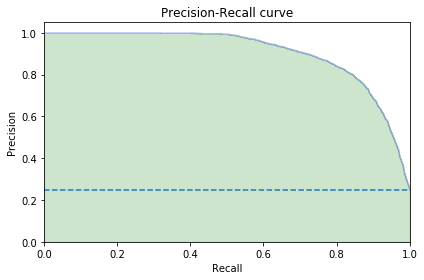

In [81]:
positive_cases = sum(truelabel)/len(truelabel)
plt.plot([0, 1], [positive_cases, positive_cases], linestyle='--')

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
plt.step(recall, precision, color='b', alpha=0.2,
            where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.tight_layout()

#### Attention weights

In [82]:
len(a_weights)

17200

### Only for True Positive Values

In [83]:
## Map predicted labels and test labels
tp = {}
i = 0
for k,v in test_label_dict.items():
    tp[k] = prediction1[i]
    i = i + 1

In [84]:
## Map predicted lables and malicious lables
tpp = {}
count = 0
i = 0
for k,v in tp.items():
    if v == 1 and test_label_dict[k] == 1:
        tpp[k] = i
    
    i += 1

In [85]:
t_mal_ids = []
for k,v in tpp.items():
    t_mal_ids.append(v)

In [86]:
len(t_mal_ids)

3345

In [87]:
tpp

{'0002D1950CC73492ADBFDA00645B13C47826A7F4299C29572F838B5F35842F01.txt': 3001,
 '000BD729004E9B29564BF6BDBDFDA5C2BFE478FC612A079FECB7584D06DCAC8C.txt': 3003,
 '001019FA9F415BB3314CDB2AFF6EE3D1236BA5ACCB15BB9D53378271F37A8412.txt': 3005,
 '0013470A1370884418FA09C1103E656E04D0CBB8D1AC3C03719B9842F9006665.txt': 3007,
 '001441793CA9066610E528C95E44C68588B0A3CA5FB853D3776C398A749DE61F.txt': 3008,
 '001443C57EF17087C45362A8F09ED58A8291D68BD753E173D1599C70E7B08B41.txt': 3009,
 '0017B67588D03D2A1E888D143B0D61596DD7BAE942AE34055997C3E9B43D5E29.txt': 3010,
 '0018D7835737A6CC73658CF53691DA6E96B35DD78AE2F653D9A955A3FA2AE440.txt': 3011,
 '001A7F9C3C1FD1D0AF24E4B038FD39AD32E9621B45D44F1DC2230EC9B7F8561C.txt': 3012,
 '0021AF05170E3919D94676533DB4EEC9FE15ED330E92E2293DDF30FA13D90C1D.txt': 3013,
 '00231CA69D8D76D9BB33E814A7EB53033905CC65C766E63495C45AB0F0D9F2CC.txt': 3014,
 '002482EEAD614A9F904749A2D1C33EF505D70B99B9716EC4824EBF941F83A4FB.txt': 3015,
 '0025FB51E69BA50FB5A26EEA3E22AC8644ED4BD42E211EC487

#### Load test data into memory as np.array

In [88]:
test_data_mem = []
for input, labels in test_generator:
    for i in input:
        x = np.array(i)
        x = x.squeeze()
        test_data_mem.append(x)


#### Get malicious filename and their index from test generator

In [89]:
# For all malware TN and FN
# true_ids = [] # ids of the malicious files from test_generator
# for i,d in enumerate(true_label):
#     if d == 1:
#         true_ids.append(i)
# # print(true_ids)

In [90]:
# t1 = {}
# count = 0
# for k,v in test_label_dict.items():
#     t1[k] = count
#     count += 1

In [91]:
# tf = {}
# for k,v in t1.items():
#     if v in true_ids:
#         tf[k] = v

In [92]:
# tf

##### For 1 example

In [99]:
train_dir = '/media/data/artifacts/2016/test/'
# Load data and get label
# f2 = '22A016ACF04241F38EA461C888C6149D9296D0685851186D9C4E86C0B64C1F1F.txt' # this also good deskeyspec
# 
# f2 = '0631D6F894C62F8B49CDB2E7B6F13E4A86EC13F339300B82385A41CB917CA8A1.txt' # this good cryptocipher
# f2 = '0AD5833E42D26E842711D5A03CD7ED2C16894E5C969C6A461209EBF045903D0E.txt' # this also good deskeyspec
# f2 = '0F811DF8F42BBFA4E3ACA41994767D4B89596E24AC8A99569A90429E9860CDD3.txt'
# f2 = '0590639FAB7FA6CA0BA79DE9ADCCC434970C3F277C00CB7FF3657E502EC8D308.txt'
# f2 = 'logstealer.txt'

#vt10

# f2 = '0402690F7661E4670426AFDEC58CB72FBF8B8340EB5654EDB0C873D295F68A86.txt'
# f2 = '0485F56635A63D8222280FC8A9A28A8DB4E15580354B01821C5F106535935ECC.txt'
# f2 = '04AA2FC7C63506655EA8F7A1D74F7F5EFC288F4C18B1F5E1D56DF6791EC43725.txt' #http
# f2 = '05B76017323EF2AFCB5CF3E5D8E9DD1137477C1E04698E59D1153056859897B1.txt'
# f2 = '05F0D542CDFA19F8E675B0CD782D7C05C4AC8E41CB7F5F4B847776EA8D6F335E.txt'
# f2 = '0641125EC87D5F3623261D1A18BBC7389A89F2A3FF1B92151B25E78B22F57936.txt'
# f2 = '0651B8AB3F64B45EF0AF192D776A01DDFCED7BCB37F8F34A09CFF8B78A23D3F1.txt' #no
# f2 = '068D6E8BC12D40B1C5339FF3FA254E2170835A2DB848F360E4A00B0F73A75C55.txt'
# f2 = '072BC2B8AFBFAF1C7D01D67CD929689DB536EC563373B245DDFF5F842D4685CD.txt' #apache
# f2 = '07636FA0B61F5DD7B84240572231A537BBC0C9DDD4D44D56CA10605F75876004.txt'
# f2 = '090870D2921D57EB349166B40A0475396088F8A89780BBD8AC8FA8C2D2C3DF5A.txt'


# f2 = '001441793CA9066610E528C95E44C68588B0A3CA5FB853D3776C398A749DE61F.txt' #short
# f2 = '001443C57EF17087C45362A8F09ED58A8291D68BD753E173D1599C70E7B08B41.txt'
# f2 = '0025FB51E69BA50FB5A26EEA3E22AC8644ED4BD42E211EC4874AD89F30499C30.txt'
# f2 = '0F811DF8F42BBFA4E3ACA41994767D4B89596E24AC8A99569A90429E9860CDD3.txt' #adware
# f2 = '0FD594AEC225D9B2CF5A018F4ADB9BD97479A09D5AB1FA41DCBF3E49EFAF36EB.txt'
# f2 = '037E6D51E9A589583FD108DAF12C3E1EF2D2BE2C78D2E89FDB20AA6B2C36286D.txt'
# f2 = '0402690F7661E4670426AFDEC58CB72FBF8B8340EB5654EDB0C873D295F68A86.txt' #good2
f2 = '0590639FAB7FA6CA0BA79DE9ADCCC434970C3F277C00CB7FF3657E502EC8D308.txt' #good1

# f2 = '0631D6F894C62F8B49CDB2E7B6F13E4A86EC13F339300B82385A41CB917CA8A1.txt'
# f2 = '0BEFE2084DCF1B1630F4A232CF8EC51D03574567A8941E55703EC4A4FF98C986.txt'

one_file = open(train_dir + f2,'r').read().strip()

X =  sequence.pad_sequences(tokenizer.texts_to_sequences([one_file]),maxlen=2000, padding='post',truncating='post')
print(X)

[[2 2 2 ... 0 0 0]]


In [100]:
tpp[f2]

7115

In [106]:
# len(a_weights[0])
len(b_weights[0])

4000

In [102]:
ts = X.squeeze().tolist()
# print(ts, end='')

In [115]:
mal_index = tpp[f2] 
m = a_weights[mal_index]
a_weights[mal_index].shape
# m = b_weights[mal_index]
# b_weights[mal_index].shape

(4000,)

In [116]:
mal_index = tpp[f2] 
dict = {}
for i in range(0,4000):
    try:
#         s = idx2word[ts[i]]
#         if s not in dict:
#             x = m[i]
#             dict[s] = x
        api_name = idx2word[ts[i]]
        wt = m[i]
        if api_name in dict:
            dict[api_name] = max(dict[api_name],wt)
        else:
            dict[api_name] = wt
    except: KeyError

cols = ['values']
df = pd.DataFrame.from_dict(dict, orient='index', columns = cols)
df = df.sort_values(by='values', ascending=False)
df.columns = ['weights']
df.head(20)

,weights
ljava/lang/reflect/field;.isaccessible:()z,0.141635
ljava/io/file;.delete:()z,0.141519
ljava/lang/reflect/array;.newinstance:(ljava/lang/class;i)ljava/lang/object;,0.121067
ljava/lang/class;.forname:(ljava/lang/string;)ljava/lang/class;,0.047151
ljava/lang/nosuchfieldexception;.<init>:(ljava/lang/string;)v,0.023995
ljava/lang/interruptedexception;.printstacktrace:()v,0.019881
ljava/lang/reflect/method;.setaccessible:(z)v,0.018509
ljava/util/arraylist;.<init>:(ljava/util/collection;)v,0.012980
ljava/lang/thread;.getname:()ljava/lang/string;,0.007661
ljava/lang/exception;.printstacktrace:(ljava/io/printstream;)v,0.007628


### Aggregate weights for ALL malicious files in test data

In [125]:
alltop50 = {}
# del dict
# t_mal_ids = [7115]
for mal_id in t_mal_ids:
    top50 = {}
#     wt = b_weights[mal_id]
    wt = a_weights[mal_id]

    for i in range(0,4000):
        try:
            s = idx2word[test_data_mem[mal_id][i]]
            x = wt[i]
            if s in top50:
                top50[s] = max(top50[s],x)
            else:
                top50[s] = x        
        except: KeyError
    top50 = {k: v for k, v in sorted(top50.items(), key=lambda item: item[1], reverse=True)} # reverse sort dict
    top50 = dict(itertools.islice(top50.items(), 100)) # get top50 top features 
    alltop50[mal_id] = top50

In [126]:
alltop50[tpp[f2]]

{'ljava/lang/interruptedexception;.printstacktrace:()v': 0.16197129,
 'ljava/lang/reflect/method;.setaccessible:(z)v': 0.15682973,
 'ljava/lang/reflect/field;.isaccessible:()z': 0.042919677,
 'ljava/lang/class;.getdeclaredfield:(ljava/lang/string;)ljava/lang/reflect/field;': 0.038622648,
 'ljava/lang/object;.notify:()v': 0.017340684,
 'ljava/lang/reflect/array;.newinstance:(ljava/lang/class;i)ljava/lang/object;': 0.016712755,
 'landroid/app/application;.onterminate:()v': 0.011520508,
 'ljava/lang/nosuchfieldexception;.<init>:(ljava/lang/string;)v': 0.010765469,
 'landroid/app/application;.ontrimmemory:(i)v': 0.009554045,
 'ljava/lang/exception;.printstacktrace:(ljava/io/printstream;)v': 0.008771947,
 'ljava/io/file;.delete:()z': 0.007978183,
 'ljava/lang/nosuchmethodexception;.<init>:(ljava/lang/string;)v': 0.006396343,
 'ljava/lang/reflect/field;.get:(ljava/lang/object;)ljava/lang/object;': 0.0063889506,
 'ljava/lang/object;.wait:()v': 0.0055602444,
 'landroid/app/application;.onconfi

In [127]:
weights = {}
count = {}
for mal_id in t_mal_ids:
    for k,v in alltop50[mal_id].items():
        if k not in weights:
            weights[k] = v
            count[k] = 1
        else:
            weights[k] = weights[k] + v
            count[k] = count[k] + 1   

In [128]:
cols = ['cumulative_weights']
df1 = pd.DataFrame.from_dict(weights, orient='index', columns = cols)
cols = ['count']
df2 = pd.DataFrame.from_dict(count, orient='index', columns = cols)
df_n = pd.concat([df1, df2], axis=1)

In [129]:
df_c = df_n
df_c = df_c.sort_values(by='cumulative_weights', ascending=False)
df_c.head(20)

,cumulative_weights,count
landroid/content/res/resources;.getassets:()landroid/content/res/assetmanager;,276.610840,1889
ljava/io/file;.getparentfile:()ljava/io/file;,253.963409,2208
ljava/lang/reflect/method;.setaccessible:(z)v,168.531143,2233
ljava/io/fileoutputstream;.write:([bii)v,99.580971,2394
landroid/util/base64;.decode:([bi)[b,34.659008,222
ljava/io/inputstream;.close:()v,25.745605,2582
ljava/lang/object;.notify:()v,22.100742,1998
ljava/io/bufferedinputstream;.available:()i,18.762272,1731
landroid/app/application;.getbasecontext:()landroid/content/context;,18.699900,1660
ljava/io/fileoutputstream;.flush:()v,16.552031,1180


In [130]:
df_n['effective_weights'] = df_n['cumulative_weights'] / df_n['count']
df_n = df_n.sort_values(by='effective_weights', ascending=False)
df_n = df_n.drop('cumulative_weights', 1)
df_n.head(40)

,count,effective_weights
landroid/webkit/webview;.getrootview:()landroid/view/view;,15,0.160272
landroid/util/base64;.decode:([bi)[b,222,0.156122
landroid/content/res/resources;.getassets:()landroid/content/res/assetmanager;,1889,0.146432
ljava/io/file;.getparentfile:()ljava/io/file;,2208,0.115020
ljava/lang/reflect/method;.setaccessible:(z)v,2233,0.075473
ljava/util/zip/inflateroutputstream;.<init>:(ljava/io/outputstream;)v,3,0.060609
landroid/util/base64outputstream;.flush:()v,4,0.042719
ljava/io/fileoutputstream;.write:([bii)v,2394,0.041596
landroid/os/parcel;.writetypedarray:([landroid/os/parcelable;i)v,6,0.038440
ljava/lang/outofmemoryerror;.<init>:()v,11,0.031605


In [ ]:
# Save features to csv

In [134]:
tra_attn = df_n.head(500)
tra_attn.to_csv(model_dir + 'test_500_tra_attn_256_1.csv', sep=',', encoding='utf-8')